### Predict Sahel Rainfall with CICMoD dataset

In this project we work with **C**limate **I**ndex **C**ollection based on **Mo**del **D**ata (CICMoD) dataset (https://github.com/MarcoLandtHayen/climate_index_collection) to predict Sahel Precipitation anomalies ("Sahel rainfall").

This work is inspired by [Badr et al., 2014](https://doi.org/10.1175/JAMC-D-13-0181.1): They tried to predict summertime (July–September) Sahel rainfall anomalies using indices of springtime (April–June) sea-surface temperature (SST) and sea air temperature (SAT) anomalies. Principal component analysis was used to remove multicollinearity between predictor variables.

To follow this approach, we use **April to June mean index values as predictors** to predict **July to September seasonal sum of Sahel precipitation anomaly index**. In the first attempt we omit applying principal component analysis. And, opposed to [Badr et al., 2014], we include sea-surface salinity (SSS) anomalies as additional input feature.

**Outline in this experiment:**
- Start with **linear regression** as benchmark.
- Try **MLP model** in a **single-run experiment**.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy as sp

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    Conv1D,
    MaxPooling1D,
    Dropout,
    Flatten,
    BatchNormalization,
    LeakyReLU,
    concatenate,
)
from tensorflow.keras.optimizers import (
    SGD,
    Adam,
)
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from cicmod_application.preprocessing import split_sequence

from numpy.testing import assert_allclose, assert_almost_equal

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Load data

Load collection of climate indices directly from GitHub release.

In [2]:
data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2022.09.09.1/climate_indices.csv"
)
climind = pd.read_csv(data_url)

# Set index: Month BEFORE year, since we want to group by month and get seasonal mean / sum for each year.
climind = climind.set_index(["model","month","year","index"]).unstack(level=-1)["value"]
climind

index                  AMO   ENSO_12    ENSO_3   ENSO_34    ENSO_4    NAO_PC  \
model month year                                                               
CESM  1     1    -0.045584  0.878723  1.793537  2.277095  1.539571  1.494980   
            2     0.065762 -0.369939 -0.411301 -0.604617 -0.543775 -0.472225   
            3     0.093188 -0.273633  0.175905  0.360535  0.817109  0.625345   
            4     0.100560  1.645187  2.363455  2.109603  1.037441 -1.710669   
            5     0.006717 -0.298098 -1.259673 -1.511350 -1.404290 -1.297533   
...                    ...       ...       ...       ...       ...       ...   
FOCI  12    996  -0.045785 -0.226950 -0.837139 -1.329104 -1.767935 -2.489885   
            997  -0.140739  0.336926  0.372891  0.363424  0.289976 -2.476904   
            998  -0.031140 -0.168636  0.051378  0.228499  0.604563 -0.320422   
            999   0.049995  0.103462  0.036816 -0.182372 -0.070128  0.353078   
            1000 -0.006059  0.284155  0.622142  1.097104  1.292274 -0.762554   

index               NAO_ST        NP    PDO_PC  PREC_SAHEL  ...   SSS_ENA  \
model month year                                            ...             
CESM  1     1     1.571751 -0.624027  0.354552   -0.000226  ...  0.377755   
            2    -0.918063 -0.426188  1.186967   -0.002682  ...  0.006887   
            3    -0.391640 -1.888244  0.922896    0.009889  ... -0.138440   
            4    -2.133493  0.272794  1.263296    0.000170  ... -0.563790   
            5    -3.603766  0.062115  0.092897    0.005747  ...  0.187125   
...                    ...       ...       ...         ...  ...       ...   
FOCI  12    996  -3.539256  0.067635  0.916682   -0.004333  ...  0.738453   
            997  -3.147132 -0.041524  0.700469   -0.006278  ...  0.020022   
            998  -0.936924  1.923619  0.455950   -0.003692  ...  0.373719   
            999   0.325810  0.536015 -0.957125    0.002825  ... -0.243904   
            1000 -0.685174  0.324010 -0.595900    0.072165  ... -0.616161   

index               SSS_NA    SSS_SA   SSS_WNA  SST_ESIO  SST_HMDR   SST_MED  \
model month year                                                               
CESM  1     1     0.361125 -0.650658  0.001022  0.483008  0.070793  0.032231   
            2    -0.168227  0.060719 -0.216479 -0.462306  0.053236  0.071033   
            3    -0.175914 -0.342111 -0.563534 -0.098334  0.124467  0.105941   
            4    -0.535536  0.197418 -0.339864  0.492548  0.269565 -0.064848   
            5     0.112920  1.331708 -0.346535 -0.213615  0.048541  0.020526   
...                    ...       ...       ...       ...       ...       ...   
FOCI  12    996   0.437155 -0.492879  0.430365 -0.447537 -0.246611 -0.008032   
            997  -0.148237 -1.521807 -0.006727  0.356411 -0.426511  0.110487   
            998   0.342083 -0.538377  0.677175  0.408447 -0.253021  0.047124   
            999  -0.287265 -0.902391  0.508716  0.101377 -0.047944  0.089229   
            1000 -0.049702  0.477039  0.880939  0.191145 -0.241239  0.089911   

index              SST_TNA   SST_TSA  SST_WSIO  
model month year                                
CESM  1     1     0.038024  0.526206 -0.316788  
            2     0.109987  0.040107  0.149966  
            3     0.099277  0.042799  0.057675  
            4     0.320109  0.193464  0.290959  
            5     0.021310 -0.064859  0.212626  
...                    ...       ...       ...  
FOCI  12    996  -0.287892  0.067875  0.287778  
            997  -0.517072  0.046964 -0.140483  
            998  -0.286908 -0.091635  0.071905  
            999  -0.052815 -0.065626  0.202035  
            1000 -0.279017  0.093415 -0.048286  

[23988 rows x 29 columns]

### Aggregate data

Need only **April to June mean index values as predictors** to predict **July to September seasonal sum of Sahel precipitation anomaly index**.

In [3]:
# Separate data by model:
climind_FOCI = climind.loc[('FOCI')]
climind_CESM = climind.loc[('CESM')]

## Aggregate data to have April to June mean AND July to September sum:

# FOCI
climind_FOCI_AMJ_mean = climind_FOCI.loc[4:6].groupby('year').mean()
climind_FOCI_JAS_sum = climind_FOCI.loc[7:9].groupby('year').sum()

# CESM
climind_CESM_AMJ_mean = climind_CESM.loc[4:6].groupby('year').mean()
climind_CESM_JAS_sum = climind_CESM.loc[7:9].groupby('year').sum()

# From AMJ mean values select all columns except 'PREC_SAHEL', since it is used as target:
climind_FOCI_AMJ_mean = climind_FOCI_AMJ_mean.loc[:, climind_FOCI_AMJ_mean.columns != 'PREC_SAHEL']
climind_CESM_AMJ_mean = climind_CESM_AMJ_mean.loc[:, climind_CESM_AMJ_mean.columns != 'PREC_SAHEL']

# From JAS sum values select only column 'PREC_SAHEL', which is used as target:
prec_sahel_FOCI_JAS = climind_FOCI_JAS_sum.loc[:, climind_FOCI_JAS_sum.columns == 'PREC_SAHEL']
prec_sahel_CESM_JAS = climind_CESM_JAS_sum.loc[:, climind_CESM_JAS_sum.columns == 'PREC_SAHEL']

### Normalize data

Make sure that all seasonal mean indices used as predictors have **zero mean** and **unit variance**.

In [4]:
# Subtract mean and divide by standard deviation:
climind_FOCI_AMJ = (
    (climind_FOCI_AMJ_mean - np.mean(climind_FOCI_AMJ_mean,axis=0)) / 
    np.std(climind_FOCI_AMJ_mean,axis=0)
)
climind_CESM_AMJ = (
    (climind_CESM_AMJ_mean - np.mean(climind_CESM_AMJ_mean,axis=0)) / 
    np.std(climind_CESM_AMJ_mean,axis=0)
)

## Check result:
# FOCI mean == 0
assert_allclose(
    actual=np.mean(climind_FOCI_AMJ,axis=0).values, 
    desired=np.zeros(len(np.mean(climind_FOCI_AMJ,axis=0).values)), 
    atol=1e-3
)
# FOCI std == 1
assert_allclose(
    actual=np.std(climind_FOCI_AMJ,axis=0).values, 
    desired=np.ones(len(np.mean(climind_FOCI_AMJ,axis=0).values)), 
    atol=1e-3
)
# CESM mean == 0
assert_allclose(
    actual=np.mean(climind_CESM_AMJ,axis=0).values, 
    desired=np.zeros(len(np.mean(climind_CESM_AMJ,axis=0).values)), 
    atol=1e-3
)
# CESM std == 1
assert_allclose(
    actual=np.std(climind_CESM_AMJ,axis=0).values, 
    desired=np.ones(len(np.mean(climind_CESM_AMJ,axis=0).values)), 
    atol=1e-3
)

### Plot target: Sahel Rainfall anomalies JAS (sum)

In [16]:
# Define function to specify bar color, according to sign of values:
def bar_color(data,color_pos,color_neg):
    return np.where(data.values>0,color_pos,color_neg).T

Text(0, 0.5, 'norm. Anomaly (CESM)')

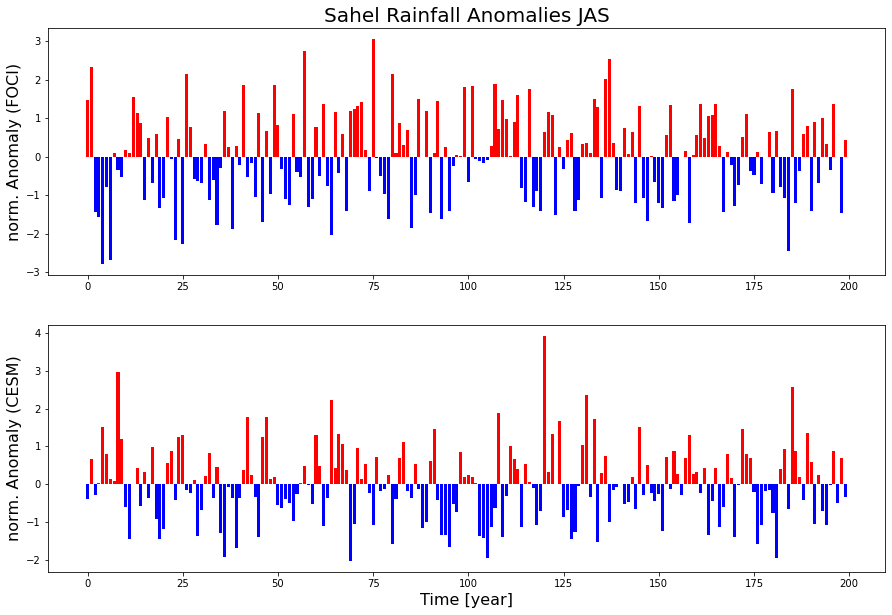

In [17]:
fig, axes = plt.subplots(2,1,figsize=[15,10])
axes[0].bar(
    x=range(len(prec_sahel_FOCI_JAS.values[:200,0])),
    height=prec_sahel_FOCI_JAS.values[:200,0],
    color=bar_color(prec_sahel_FOCI_JAS,'r','b')[0]
)
axes[1].bar(
    x=range(len(prec_sahel_CESM_JAS.values[:200,0])),
    height=prec_sahel_CESM_JAS.values[:200,0],
    color=bar_color(prec_sahel_CESM_JAS,'r','b')[0]
)
axes[0].set_title('Sahel Rainfall Anomalies JAS', fontsize=20)
axes[1].set_xlabel('Time [year]', fontsize=16)
axes[0].set_ylabel('norm. Anomaly (FOCI)', fontsize=16)
axes[1].set_ylabel('norm. Anomaly (CESM)', fontsize=16)

### Prepare inputs and targets

In [5]:
## Split inputs and targets into train and validation sets (80:20):

# Get split point:
split = int(len(climind_FOCI_AMJ) * 0.8)

train_input_FOCI = climind_FOCI_AMJ[:split]
val_input_FOCI = climind_FOCI_AMJ[split:]
train_input_CESM = climind_CESM_AMJ[:split]
val_input_CESM = climind_CESM_AMJ[split:]

train_target_FOCI = prec_sahel_FOCI_JAS[:split]
val_target_FOCI = prec_sahel_FOCI_JAS[split:]
train_target_CESM = prec_sahel_CESM_JAS[:split]
val_target_CESM = prec_sahel_CESM_JAS[split:]

# Check dimensions:
print("train_input_FOCI shape (samples, features): ", train_input_FOCI.shape)
print("train_input_CESM shape (samples, features): ", train_input_CESM.shape)
print("val_input_FOCI shape (samples, features): ", val_input_FOCI.shape)
print("val_input_CESM shape (samples, features): ", val_input_CESM.shape)
print("\ntrain_target_FOCI shape (samples, features): ", train_target_FOCI.shape)
print("train_target_CESM shape (samples, features): ", train_target_CESM.shape)
print("val_target_FOCI shape (samples, features): ", val_target_FOCI.shape)
print("val_target_CESM shape (samples, features): ", val_target_CESM.shape)

train_input_FOCI shape (samples, features):  (800, 28)
train_input_CESM shape (samples, features):  (800, 28)
val_input_FOCI shape (samples, features):  (200, 28)
val_input_CESM shape (samples, features):  (199, 28)

train_target_FOCI shape (samples, features):  (800, 1)
train_target_CESM shape (samples, features):  (800, 1)
val_target_FOCI shape (samples, features):  (200, 1)
val_target_CESM shape (samples, features):  (199, 1)


In [130]:
# Optionally pick a reduced set of input features to train the models:
# train_input_FOCI = train_input_FOCI[['SAT_N_ALL', 'SAT_N_LAND', 'SAT_N_OCEAN']]
# val_input_FOCI = val_input_FOCI[['SAT_N_ALL', 'SAT_N_LAND', 'SAT_N_OCEAN']]

### Try linear regression to set the benchmark

#### Nomenclature and mathematical background on linear regression

We apply multi-linear regression and use **April to June mean index values as predictors** to predict **July to September seasonal sum of Sahel precipitation anomaly index**. 

Inputs have dimension (samples, features), targets have timension (samples, 1). We are looking for weights $W$ with shape (features, 1) and bias $b$ as single value.

The relation between train inputs $U$, weights, bias and train targets $Y$ reads:

$$U \cdot W + \overline{b} = Y$$

Note: Here $\overline{b}$ denotes a vector of shape (samples, 1), containing only the single output bias value $b$.

We switch to "augmented" notation and include ${b}$ as additional weight in $W$. This requires to add a column of *ones* as last column of $U$, for keeping dimensions right. This leads to:

$$U' \cdot W' = Y$$

where $U'$ and $W'$ denote train inputs and weights in augmented notation, respectively. 

Solving for $W'$ we need to invert $U'$, or get the pseudo-inverse $U'_{inv}$, since $U'$ is usually not a square matrix:

$$W' = U'_{inv} \cdot Y$$

Doing this, we obtain trained weights (including bias) and stick to augmented notation. To get predictions on validation inputs we also need to add a column of *ones* as last column to validation inputs.

In [18]:
### Linear regression on FOCI data

# Create vector of shape (samples, 1) containing ONEs to be added as additional column to train and val inputs.
train_input_add = np.ones((train_input_FOCI.shape[0], 1))
val_input_add = np.ones((val_input_FOCI.shape[0], 1))

# Now add vector of ONEs as additional column to train and validation inputs, omit time dimension:
train_input_prime = np.concatenate((train_input_FOCI.values[:,:], train_input_add), axis=-1)
val_input_prime = np.concatenate((val_input_FOCI.values[:,:], val_input_add), axis=-1)

# Then need pseudo-inverse of train inputs in augmented notation
train_input_prime_inv = np.linalg.pinv(train_input_prime)

# Then get output weights, in augmented notation
W_prime = np.matmul(train_input_prime_inv, train_target_FOCI.values)

# Now extract weights and bias from augmented notation (W_prime), the last value is the bias:
W = W_prime[:-1,0]
b = W_prime[-1,0]

## Get model predictions on train and validation data:
train_pred_linReg_FOCI = np.matmul(train_input_prime, W_prime)
val_pred_linReg_FOCI = np.matmul(val_input_prime, W_prime)

Text(0, 0.5, 'norm. Anomaly (FOCI)')

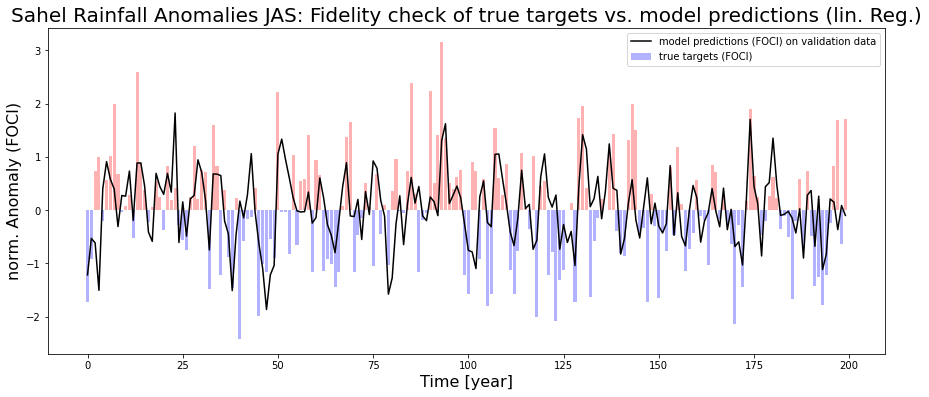

In [19]:
# Fidelity check: Plot VALIDATION targets as bar plot (red / blue) vs. predictions as black line (FOCI)
fig, ax = plt.subplots(1,1,figsize=[15,6])
ax.bar(
    x=range(len(prec_sahel_FOCI_JAS.values[split:,0])),
    height=prec_sahel_FOCI_JAS.values[split:,0],
    color=bar_color(prec_sahel_FOCI_JAS[split:],'r','b')[0],
    label="true targets (FOCI)",
    alpha=0.3
)
ax.plot(val_pred_linReg_FOCI, label="model predictions (FOCI) on validation data", color='black')
ax.legend()
ax.set_title('Sahel Rainfall Anomalies JAS: Fidelity check of true targets vs. model predictions (lin. Reg.)', fontsize=20)
ax.set_xlabel('Time [year]', fontsize=16)
ax.set_ylabel('norm. Anomaly (FOCI)', fontsize=16)

In [20]:
# Check loss (mse) of true targets vs. model predictions:
print("Mean-squared error on train data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((train_pred_linReg_FOCI[:,0] - train_target_FOCI.values[:,0])**2),3))
print("Mean-squared error on validation data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((val_pred_linReg_FOCI[:,0] - val_target_FOCI.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_FOCI[:,0], train_target_FOCI.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_FOCI[:,0], val_target_FOCI.values[:,0]]))[0,1],3)
     )

## Get binary contingency table: TP, FP, TN, FN

# Training data:
TP_linReg_FOCI_train = np.sum(((train_target_FOCI.values>0)==(train_pred_linReg_FOCI>0)) & (train_target_FOCI.values>0)) / sum(train_target_FOCI.values>0)
FP_linReg_FOCI_train = np.sum(((train_target_FOCI.values<0)==(train_pred_linReg_FOCI>0)) & (train_target_FOCI.values<0)) / sum(train_target_FOCI.values<0)
TN_linReg_FOCI_train = np.sum(((train_target_FOCI.values<0)==(train_pred_linReg_FOCI<0)) & (train_target_FOCI.values<0)) / sum(train_target_FOCI.values<0)
FN_linReg_FOCI_train = np.sum(((train_target_FOCI.values>0)==(train_pred_linReg_FOCI<0)) & (train_target_FOCI.values>0)) / sum(train_target_FOCI.values>0)

# Validation data:
TP_linReg_FOCI_val = np.sum(((val_target_FOCI.values>0)==(val_pred_linReg_FOCI>0)) & (val_target_FOCI.values>0)) / sum(val_target_FOCI.values>0)
FP_linReg_FOCI_val = np.sum(((val_target_FOCI.values<0)==(val_pred_linReg_FOCI>0)) & (val_target_FOCI.values<0)) / sum(val_target_FOCI.values<0)
TN_linReg_FOCI_val = np.sum(((val_target_FOCI.values<0)==(val_pred_linReg_FOCI<0)) & (val_target_FOCI.values<0)) / sum(val_target_FOCI.values<0)
FN_linReg_FOCI_val = np.sum(((val_target_FOCI.values>0)==(val_pred_linReg_FOCI<0)) & (val_target_FOCI.values>0)) / sum(val_target_FOCI.values>0)

print("\nlinear Regression, FOCI:\n     TRAIN   VALIDATION")
print("TP: ", np.round(TP_linReg_FOCI_train[0],3),"  ", np.round(TP_linReg_FOCI_val[0],3))
print("FP: ", np.round(FP_linReg_FOCI_train[0],3),"  ",  np.round(FP_linReg_FOCI_val[0],3))
print("TN: ", np.round(TN_linReg_FOCI_train[0],3),"  ",  np.round(TN_linReg_FOCI_val[0],3))
print("FN: ", np.round(FN_linReg_FOCI_train[0],3),"  ",  np.round(FN_linReg_FOCI_val[0],3))

Mean-squared error on train data (FOCI) with lin. Reg.:  0.864
Mean-squared error on validation data (FOCI) with lin. Reg.:  0.827

Correlation on train data (FOCI) with lin. Reg.:  0.547
Correlation on validation data (FOCI) with lin. Reg.:  0.496

linear Regression, FOCI:
     TRAIN   VALIDATION
TP:  0.703    0.722
FP:  0.338    0.359
TN:  0.662    0.641
FN:  0.297    0.278


In [21]:
### Linear regression on CESM data

# Create vector of shape (samples, 1) containing ONEs to be added as additional column to train and val inputs.
train_input_add = np.ones((train_input_CESM.shape[0], 1))
val_input_add = np.ones((val_input_CESM.shape[0], 1))

# Now add vector of ONEs as additional column to train and validation inputs, omit time dimension:
train_input_prime = np.concatenate((train_input_CESM.values[:,:], train_input_add), axis=-1)
val_input_prime = np.concatenate((val_input_CESM.values[:,:], val_input_add), axis=-1)

# Then need pseudo-inverse of train inputs in augmented notation
train_input_prime_inv = np.linalg.pinv(train_input_prime)

# Then get output weights, in augmented notation
W_prime = np.matmul(train_input_prime_inv, train_target_CESM.values)

# Now extract weights and bias from augmented notation (W_prime), the last value is the bias:
W = W_prime[:-1,0]
b = W_prime[-1,0]

## Get model predictions on train and validation data:
train_pred_linReg_CESM = np.matmul(train_input_prime, W_prime)
val_pred_linReg_CESM = np.matmul(val_input_prime, W_prime)

Text(0, 0.5, 'norm. Anomaly (CESM)')

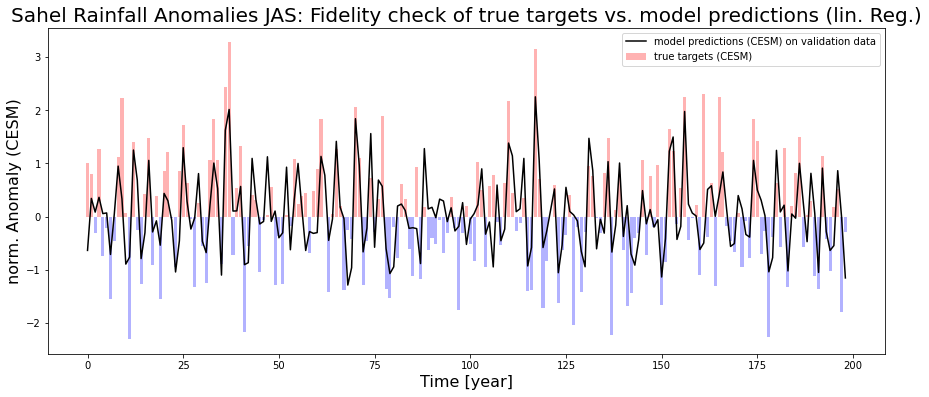

In [22]:
# Fidelity check: Plot VALIDATION targets as bar plot (red / blue) vs. predictions as black line (CESM)
fig, ax = plt.subplots(1,1,figsize=[15,6])
ax.bar(
    x=range(len(prec_sahel_CESM_JAS.values[split:,0])),
    height=prec_sahel_CESM_JAS.values[split:,0],
    color=bar_color(prec_sahel_CESM_JAS[split:],'r','b')[0],
    label="true targets (CESM)",
    alpha=0.3
)
ax.plot(val_pred_linReg_CESM, label="model predictions (CESM) on validation data", color='black')
ax.legend()
ax.set_title('Sahel Rainfall Anomalies JAS: Fidelity check of true targets vs. model predictions (lin. Reg.)', fontsize=20)
ax.set_xlabel('Time [year]', fontsize=16)
ax.set_ylabel('norm. Anomaly (CESM)', fontsize=16)

In [23]:
# Check loss (mse) of true targets vs. model predictions:
print("Mean-squared error on train data (CESM) with lin. Reg.: ", 
      np.round(np.mean((train_pred_linReg_CESM[:,0] - train_target_CESM.values[:,0])**2),3))
print("Mean-squared error on validation data (CESM) with lin. Reg.: ", 
      np.round(np.mean((val_pred_linReg_CESM[:,0] - val_target_CESM.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (CESM) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_CESM[:,0], train_target_CESM.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (CESM) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_CESM[:,0], val_target_CESM.values[:,0]]))[0,1],3)
     )

## Get binary contingency table: TP, FP, TN, FN

# Training data:
TP_linReg_CESM_train = np.sum(((train_target_CESM.values>0)==(train_pred_linReg_CESM>0)) & (train_target_CESM.values>0)) / sum(train_target_CESM.values>0)
FP_linReg_CESM_train = np.sum(((train_target_CESM.values<0)==(train_pred_linReg_CESM>0)) & (train_target_CESM.values<0)) / sum(train_target_CESM.values<0)
TN_linReg_CESM_train = np.sum(((train_target_CESM.values<0)==(train_pred_linReg_CESM<0)) & (train_target_CESM.values<0)) / sum(train_target_CESM.values<0)
FN_linReg_CESM_train = np.sum(((train_target_CESM.values>0)==(train_pred_linReg_CESM<0)) & (train_target_CESM.values>0)) / sum(train_target_CESM.values>0)

# Validation data:
TP_linReg_CESM_val = np.sum(((val_target_CESM.values>0)==(val_pred_linReg_CESM>0)) & (val_target_CESM.values>0)) / sum(val_target_CESM.values>0)
FP_linReg_CESM_val = np.sum(((val_target_CESM.values<0)==(val_pred_linReg_CESM>0)) & (val_target_CESM.values<0)) / sum(val_target_CESM.values<0)
TN_linReg_CESM_val = np.sum(((val_target_CESM.values<0)==(val_pred_linReg_CESM<0)) & (val_target_CESM.values<0)) / sum(val_target_CESM.values<0)
FN_linReg_CESM_val = np.sum(((val_target_CESM.values>0)==(val_pred_linReg_CESM<0)) & (val_target_CESM.values>0)) / sum(val_target_CESM.values>0)

print("\nlinear Regression, CESM:\n     TRAIN   VALIDATION")
print("TP: ", np.round(TP_linReg_CESM_train[0],3),"  ", np.round(TP_linReg_CESM_val[0],3))
print("FP: ", np.round(FP_linReg_CESM_train[0],3),"  ", np.round(FP_linReg_CESM_val[0],3))
print("TN: ", np.round(TN_linReg_CESM_train[0],3),"  ", np.round(TN_linReg_CESM_val[0],3))
print("FN: ", np.round(FN_linReg_CESM_train[0],3),"  ", np.round(FN_linReg_CESM_val[0],3))

Mean-squared error on train data (CESM) with lin. Reg.:  0.492
Mean-squared error on validation data (CESM) with lin. Reg.:  0.617

Correlation on train data (CESM) with lin. Reg.:  0.701
Correlation on validation data (CESM) with lin. Reg.:  0.682

linear Regression, CESM:
     TRAIN   VALIDATION
TP:  0.715    0.75
FP:  0.259    0.308
TN:  0.741    0.692
FN:  0.285    0.25


### Set up multi-layer perceptron (MLP) for single run experiments on FOCI and CESM data

In [24]:
# Define customized metric function to compute Pearson's correlation coefficient 
# on true targets and model predictions.

def correlation_coefficient(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    sx = K.std(x)
    sy = K.std(y)
    xm, ym = x-mx, y-my
    r = K.mean(xm * ym) / (sx * sy)
    return r

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                580       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
80/80 - 0s - loss: 1.6380 - val_loss: 1.1157
Epoch 2/10
80/80 - 0s - loss: 1.0854 - val_loss: 0.9196
Epoch 3/10
80/80 - 0s - loss: 0.9685 - val_loss: 0.8310
Epoch 4/10
80/80 - 0s - loss: 0.9338 - val_loss: 0.8035
Epoch 5/10
80/80 - 0s - loss: 0.9273 - 

KeyError: 'correlation_coefficient'

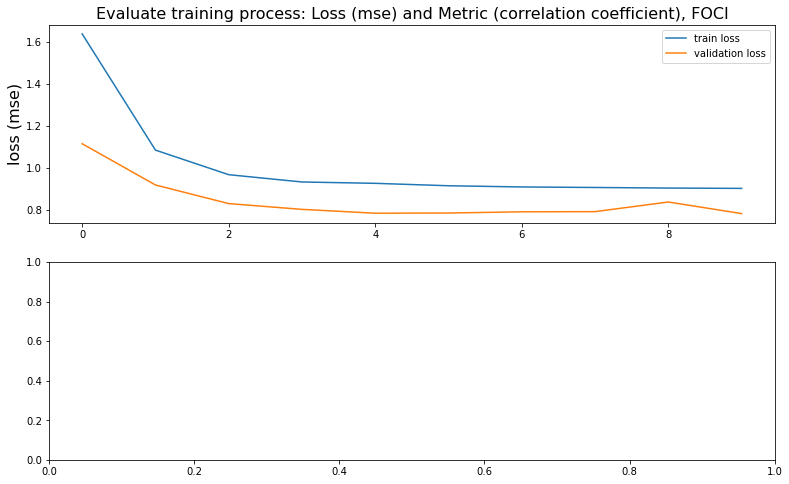

In [25]:
## MLP on FOCI:

## Set parameters upfront:
lr = 0.0005 # Learning rate
epc = 10 # Number of epochs
batch_size = 10 # Batch size
in_features = train_input_FOCI.shape[1] # Number of input features

# Optionally use L1 and/or L2 regularization drive small weights and/or bias to zero or penalize large weights
# and/or bias, respectively:
kernel_reg_Dense=tfr.l1_l2(l1=0, l2=0)
bias_reg_Dense=tfr.l1_l2(l1=0, l2=0) 

# Set up layers:
inputs = Input(shape=(in_features))
hidden_1 = Dense(20, activation='linear', kernel_regularizer=kernel_reg_Dense)(inputs)
hidden_2 = Dense(10, activation='linear', kernel_regularizer=kernel_reg_Dense)(hidden_1)
output = Dense(1, activation='linear')(hidden_2)

## Alternatively try more hidden layers with ReLU activation:
# # Set up layers:
# inputs = Input(shape=(in_features))
# hidden_1 = Dense(30, activation='relu')(inputs)
# hidden_2 = Dense(30, activation='relu')(hidden_1)
# hidden_3 = Dense(30, activation='relu')(hidden_2)
# hidden_4 = Dense(30, activation='relu')(hidden_3)
# output = Dense(1, activation='linear')(hidden_4)

# Define and compile model :
model_MLP = Model(inputs, output, name='MLP')
opt = Adam(lr=lr) #SGD(lr=lr)
model_MLP.compile(loss='mse', optimizer=opt, metrics=[correlation_coefficient])
model_MLP.summary()

## train model on FOCI data:
history = model_MLP.fit(train_input_FOCI, train_target_FOCI, epochs=epc, verbose=2, shuffle=True,
                    batch_size=batch_size, validation_data=(val_input_FOCI, val_target_FOCI))

# Plot loss (mse) and metric (correlation coefficient) on train and validation data (FOCI):
fig, axes = plt.subplots(2, 1, figsize=(13,8))
axes[0].set_title("Evaluate training process: Loss (mse) and Metric (correlation coefficient), FOCI", fontsize=16)
axes[0].plot(history.history['loss'], label='train loss'), 
axes[0].plot(history.history['val_loss'], label='validation loss')
axes[0].set_ylabel("loss (mse)", fontsize=16)
axes[0].legend()
axes[1].plot(history.history['correlation_coefficient'], label='train correlation'), 
axes[1].plot(history.history['val_correlation_coefficient'], label='validation correlation')
axes[1].set_ylabel("Correlation Coeff", fontsize=16)
axes[1].legend()
axes[1].set_xlabel("Epoch", fontsize=16)
plt.show()

## Get model predictions on train and validation data:
train_pred_MLP_FOCI = model_MLP.predict(train_input_FOCI)
val_pred_MLP_FOCI = model_MLP.predict(val_input_FOCI)

In [35]:
## Save and re-load trained MLP model trained on FOCI data:

# !!! Note: To train and re-load model, need to omit customized metric in compiling statement !!!

# ## Saved models for MLP experiments on FOCI inputs:
# model_MLP.save('../models/MLP_final/model_MLP_FOCI_SahelRain')


# ## Reload trained MLP model:
# model_MLP = tf.keras.models.load_model('../models/MLP_final/model_MLP_FOCI_SahelRain')

# ## Get model predictions on train and validation data:
# train_pred_MLP_FOCI = model_MLP.predict(train_input_FOCI)
# val_pred_MLP_FOCI = model_MLP.predict(val_input_FOCI)

Text(0, 0.5, 'norm. Anomaly (FOCI)')

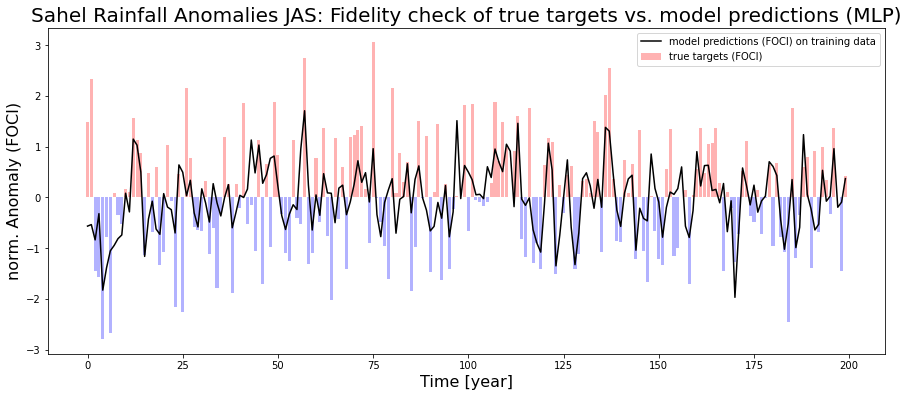

In [36]:
# Fidelity check: Plot TRAIN targets (first 200 steps) as bar plot (red / blue) vs. predictions as black line (FOCI)
fig, ax = plt.subplots(1,1,figsize=[15,6])
ax.bar(
    x=range(len(prec_sahel_FOCI_JAS.values[:200,0])),
    height=prec_sahel_FOCI_JAS.values[:200,0],
    color=bar_color(prec_sahel_FOCI_JAS[:200],'r','b')[0],
    label="true targets (FOCI)",
    alpha=0.3
)
ax.plot(train_pred_MLP_FOCI[:200], label="model predictions (FOCI) on training data", color='black')
ax.legend()
ax.set_title('Sahel Rainfall Anomalies JAS: Fidelity check of true targets vs. model predictions (MLP)', fontsize=20)
ax.set_xlabel('Time [year]', fontsize=16)
ax.set_ylabel('norm. Anomaly (FOCI)', fontsize=16)

Text(0, 0.5, 'norm. Anomaly (FOCI)')

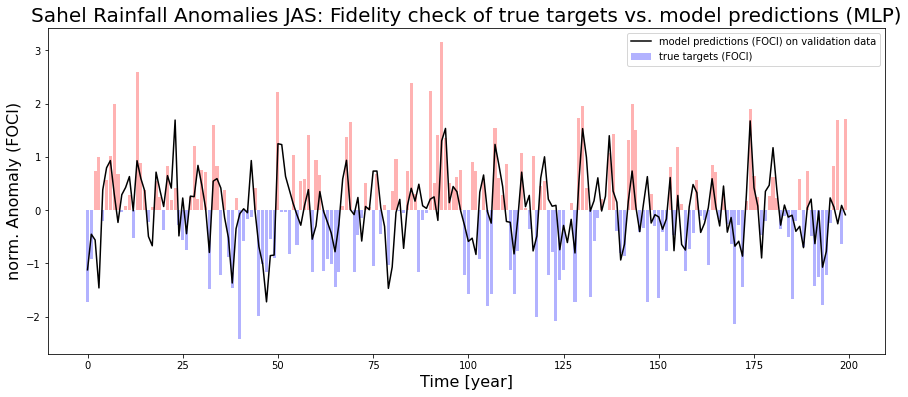

In [37]:
# Fidelity check: Plot VALIDATION targets as bar plot (red / blue) vs. predictions as black line (FOCI)
fig, ax = plt.subplots(1,1,figsize=[15,6])
ax.bar(
    x=range(len(prec_sahel_FOCI_JAS.values[split:,0])),
    height=prec_sahel_FOCI_JAS.values[split:,0],
    color=bar_color(prec_sahel_FOCI_JAS[split:],'r','b')[0],
    label="true targets (FOCI)",
    alpha=0.3
)
ax.plot(val_pred_MLP_FOCI, label="model predictions (FOCI) on validation data", color='black')
ax.legend()
ax.set_title('Sahel Rainfall Anomalies JAS: Fidelity check of true targets vs. model predictions (MLP)', fontsize=20)
ax.set_xlabel('Time [year]', fontsize=16)
ax.set_ylabel('norm. Anomaly (FOCI)', fontsize=16)

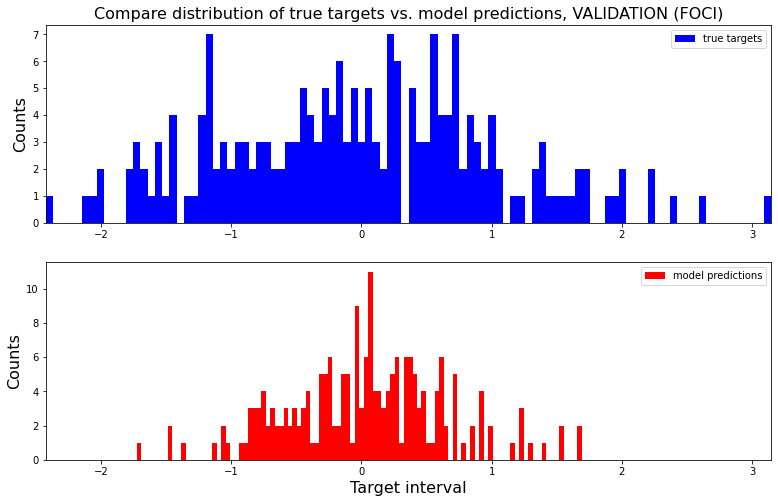

In [38]:
# Plot histogram of true targets and predictions (FOCI)
nBins = 100
fig, axes = plt.subplots(2, 1, figsize=(13,8))
axes[0].hist(val_target_FOCI.values[:,0], nBins, color="blue", label="true targets")
axes[0].set_ylabel("Counts", fontsize=16)
axes[0].legend()
axes[0].set_xlim(left=min(val_target_FOCI.values[:,0]), right=max(val_target_FOCI.values[:,0]))
axes[1].hist(val_pred_MLP_FOCI[:,0], nBins, color="red", label="model predictions")
axes[1].set_ylabel("Counts", fontsize=16)
axes[1].legend()
axes[1].set_xlim(left=min(val_target_FOCI.values[:,0]), right=max(val_target_FOCI.values[:,0]))
axes[1].set_xlabel("Target interval", fontsize=16)
axes[0].set_title("Compare distribution of true targets vs. model predictions, VALIDATION (FOCI)", fontsize=16)
plt.show()

In [39]:
## Results from MLP model (FOCI):

# Check loss (mse) of true targets vs. model predictions:
print("MLP:\n====\nMean-squared error on train data (FOCI) with MLP: ", 
      np.round(np.mean((train_pred_MLP_FOCI[:,0] - train_target_FOCI.values[:,0])**2),3))
print("Mean-squared error on validation data (FOCI) with MLP: ", 
      np.round(np.mean((val_pred_MLP_FOCI[:,0] - val_target_FOCI.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (FOCI) with MLP: ",
      np.round(np.corrcoef(np.stack([train_pred_MLP_FOCI[:,0], train_target_FOCI.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (FOCI) with MLP: ",
      np.round(np.corrcoef(np.stack([val_pred_MLP_FOCI[:,0], val_target_FOCI.values[:,0]]))[0,1],3)
     )

## Compare with benchmark results from lin. Regression

# Check loss (mse) of true targets vs. model predictions:
print("\n\nlin. Regression:\n================\nMean-squared error on train data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((train_pred_linReg_FOCI[:,0] - train_target_FOCI.values[:,0])**2),3))
print("Mean-squared error on validation data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((val_pred_linReg_FOCI[:,0] - val_target_FOCI.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_FOCI[:,0], train_target_FOCI.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_FOCI[:,0], val_target_FOCI.values[:,0]]))[0,1],3)
     )

MLP:
====
Mean-squared error on train data (FOCI) with MLP:  0.881
Mean-squared error on validation data (FOCI) with MLP:  0.783

Correlation on train data (FOCI) with MLP:  0.534
Correlation on validation data (FOCI) with MLP:  0.523


lin. Regression:
Mean-squared error on train data (FOCI) with lin. Reg.:  0.864
Mean-squared error on validation data (FOCI) with lin. Reg.:  0.827

Correlation on train data (FOCI) with lin. Reg.:  0.547
Correlation on validation data (FOCI) with lin. Reg.:  0.496


In [40]:
# Check correlation of predictions from MLP and lin. regression (FOCI):
print("Correlation of predictions on train data from MLP and lin. Reg. (FOCI): ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_FOCI[:,0], train_pred_MLP_FOCI[:,0]]))[0,1],3)
     )
print("Correlation of predictions on validation data from MLP and lin. Reg. (FOCI): ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_FOCI[:,0], val_pred_MLP_FOCI[:,0]]))[0,1],3)
     )

Correlation of predictions on train data from MLP and lin. Reg. (FOCI):  0.977
Correlation of predictions on validation data from MLP and lin. Reg. (FOCI):  0.976


In [48]:
## Get binary contingency table: TP, FP, TN, FN

# TRAINING
TP_MLP_FOCI_train = np.sum(((train_target_FOCI.values>0)==(train_pred_MLP_FOCI>0)) & (train_target_FOCI.values>0)) / sum(train_target_FOCI.values>0)
FP_MLP_FOCI_train = np.sum(((train_target_FOCI.values<0)==(train_pred_MLP_FOCI>0)) & (train_target_FOCI.values<0)) / sum(train_target_FOCI.values<0)
TN_MLP_FOCI_train = np.sum(((train_target_FOCI.values<0)==(train_pred_MLP_FOCI<0)) & (train_target_FOCI.values<0)) / sum(train_target_FOCI.values<0)
FN_MLP_FOCI_train = np.sum(((train_target_FOCI.values>0)==(train_pred_MLP_FOCI<0)) & (train_target_FOCI.values>0)) / sum(train_target_FOCI.values>0)

# VALIDATION
TP_MLP_FOCI_val = np.sum(((val_target_FOCI.values>0)==(val_pred_MLP_FOCI>0)) & (val_target_FOCI.values>0)) / sum(val_target_FOCI.values>0)
FP_MLP_FOCI_val = np.sum(((val_target_FOCI.values<0)==(val_pred_MLP_FOCI>0)) & (val_target_FOCI.values<0)) / sum(val_target_FOCI.values<0)
TN_MLP_FOCI_val = np.sum(((val_target_FOCI.values<0)==(val_pred_MLP_FOCI<0)) & (val_target_FOCI.values<0)) / sum(val_target_FOCI.values<0)
FN_MLP_FOCI_val = np.sum(((val_target_FOCI.values>0)==(val_pred_MLP_FOCI<0)) & (val_target_FOCI.values>0)) / sum(val_target_FOCI.values>0)

print("\nMLP, FOCI:\n     TRAIN    VALIDATION")
print("TP: ", np.round(TP_MLP_FOCI_train[0],3),"  ", np.round(TP_MLP_FOCI_val[0],3))
print("FP: ", np.round(FP_MLP_FOCI_train[0],3),"  ", np.round(FP_MLP_FOCI_val[0],3))
print("TN: ", np.round(TN_MLP_FOCI_train[0],3),"  ", np.round(TN_MLP_FOCI_val[0],3))
print("FN: ", np.round(FN_MLP_FOCI_train[0],3),"  ", np.round(FN_MLP_FOCI_val[0],3))

print("\n\nlinear Regression, FOCI:\n     TRAIN   VALIDATION")
print("TP: ", np.round(TP_linReg_FOCI_train[0],3),"  ", np.round(TP_linReg_FOCI_val[0],3))
print("FP: ", np.round(FP_linReg_FOCI_train[0],3),"  ", np.round(FP_linReg_FOCI_val[0],3))
print("TN: ", np.round(TN_linReg_FOCI_train[0],3),"  ", np.round(TN_linReg_FOCI_val[0],3))
print("FN: ", np.round(FN_linReg_FOCI_train[0],3),"  ", np.round(FN_linReg_FOCI_val[0],3))


MLP, FOCI:
     TRAIN    VALIDATION
TP:  0.695    0.742
FP:  0.348    0.35
TN:  0.652    0.65
FN:  0.305    0.258


linear Regression, FOCI:
     TRAIN   VALIDATION
TP:  0.703    0.722
FP:  0.338    0.359
TN:  0.662    0.641
FN:  0.297    0.278


Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 20)                580       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
80/80 - 0s - loss: 1.2035 - val_loss: 0.7907
Epoch 2/10
80/80 - 0s - loss: 0.6446 - val_loss: 0.6332
Epoch 3/10
80/80 - 0s - loss: 0.5753 - val_loss: 0.6178
Epoch 4/10
80/80 - 0s - loss: 0.5548 - val_loss: 0.5926
Epoch 5/10
80/80 - 0s - loss: 0.5461 - 

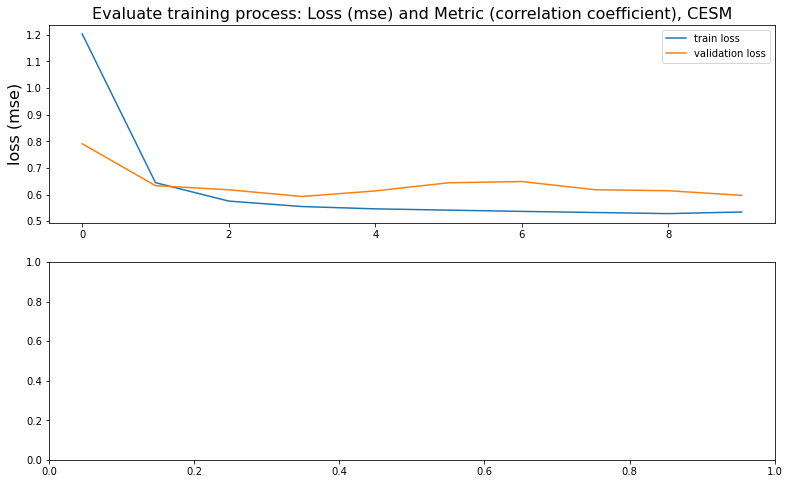

In [42]:
## MLP on CESM:

## Set parameters upfront:
lr = 0.0005 # Learning rate
epc = 10 # Number of epochs
batch_size = 10 # Batch size
in_features = train_input_CESM.shape[1] # Number of input features

# Optionally use L1 and/or L2 regularization drive small weights and/or bias to zero or penalize large weights
# and/or bias, respectively:
kernel_reg_Dense=tfr.l1_l2(l1=0, l2=0)
bias_reg_Dense=tfr.l1_l2(l1=0, l2=0) 

# Set up layers:
inputs = Input(shape=(in_features))
hidden_1 = Dense(20, activation='linear', kernel_regularizer=kernel_reg_Dense)(inputs)
hidden_2 = Dense(10, activation='linear', kernel_regularizer=kernel_reg_Dense)(hidden_1)
output = Dense(1, activation='linear')(hidden_2)

## Alternatively try more hidden layers with ReLU activation:
# # Set up layers:
# inputs = Input(shape=(in_features))
# hidden_1 = Dense(30, activation='relu')(inputs)
# hidden_2 = Dense(30, activation='relu')(hidden_1)
# hidden_3 = Dense(30, activation='relu')(hidden_2)
# hidden_4 = Dense(30, activation='relu')(hidden_3)
# output = Dense(1, activation='linear')(hidden_4)

# Define and compile model :
model_MLP = Model(inputs, output, name='MLP')
opt = Adam(lr=lr) #SGD(lr=lr)
model_MLP.compile(loss='mse', optimizer=opt, metrics=[correlation_coefficient])
model_MLP.summary()

## train model on FOCI data:
history = model_MLP.fit(train_input_CESM, train_target_CESM, epochs=epc, verbose=2, shuffle=True,
                    batch_size=batch_size, validation_data=(val_input_CESM, val_target_CESM))

# Plot loss (mse) and metric (correlation coefficient) on train and validation data (FOCI):
fig, axes = plt.subplots(2, 1, figsize=(13,8))
axes[0].set_title("Evaluate training process: Loss (mse) and Metric (correlation coefficient), CESM", fontsize=16)
axes[0].plot(history.history['loss'], label='train loss'), 
axes[0].plot(history.history['val_loss'], label='validation loss')
axes[0].set_ylabel("loss (mse)", fontsize=16)
axes[0].legend()
axes[1].plot(history.history['correlation_coefficient'], label='train correlation'), 
axes[1].plot(history.history['val_correlation_coefficient'], label='validation correlation')
axes[1].set_ylabel("Correlation Coeff", fontsize=16)
axes[1].legend()
axes[1].set_xlabel("Epoch", fontsize=16)
plt.show()

## Get model predictions on train and validation data:
train_pred_MLP_CESM = model_MLP.predict(train_input_CESM)
val_pred_MLP_CESM = model_MLP.predict(val_input_CESM)

In [46]:
## Save and re-load trained MLP model trained on CESM data:

# !!! Note: To train and re-load model, need to omit customized metric in compiling statement !!!

# ## Saved models for MLP experiments on CESM inputs:
# model_MLP.save('../models/MLP_final/model_MLP_CESM_SahelRain')


# ## Reload trained MLP model:
# model_MLP = tf.keras.models.load_model('../models/MLP_final/model_MLP_CESM_SahelRain')

# ## Get model predictions on train and validation data:
# train_pred_MLP_CESM = model_MLP.predict(train_input_CESM)
# val_pred_MLP_CESM = model_MLP.predict(val_input_CESM)

In [47]:
## Results from MLP model (CESM):

# Check loss (mse) of true targets vs. model predictions:
print("MLP:\n====\nMean-squared error on train data (CESM) with MLP: ", 
      np.round(np.mean((train_pred_MLP_CESM[:,0] - train_target_CESM.values[:,0])**2),3))
print("Mean-squared error on validation data (CESM) with MLP: ", 
      np.round(np.mean((val_pred_MLP_CESM[:,0] - val_target_CESM.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (CESM) with MLP: ",
      np.round(np.corrcoef(np.stack([train_pred_MLP_CESM[:,0], train_target_CESM.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (CESM) with MLP: ",
      np.round(np.corrcoef(np.stack([val_pred_MLP_CESM[:,0], val_target_CESM.values[:,0]]))[0,1],3)
     )

## Compare with benchmark results from lin. Regression

# Check loss (mse) of true targets vs. model predictions:
print("\n\nlin. Regression:\n================\nMean-squared error on train data (CESM) with lin. Reg.: ", 
      np.round(np.mean((train_pred_linReg_CESM[:,0] - train_target_CESM.values[:,0])**2),3))
print("Mean-squared error on validation data (CESM) with lin. Reg.: ", 
      np.round(np.mean((val_pred_linReg_CESM[:,0] - val_target_CESM.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (CESM) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_CESM[:,0], train_target_CESM.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (CESM) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_CESM[:,0], val_target_CESM.values[:,0]]))[0,1],3)
     )

MLP:
====
Mean-squared error on train data (CESM) with MLP:  0.513
Mean-squared error on validation data (CESM) with MLP:  0.597

Correlation on train data (CESM) with MLP:  0.686
Correlation on validation data (CESM) with MLP:  0.694


lin. Regression:
Mean-squared error on train data (CESM) with lin. Reg.:  0.492
Mean-squared error on validation data (CESM) with lin. Reg.:  0.617

Correlation on train data (CESM) with lin. Reg.:  0.701
Correlation on validation data (CESM) with lin. Reg.:  0.682


In [49]:
## Get binary contingency table: TP, FP, TN, FN

# TRAINING
TP_MLP_CESM_train = np.sum(((train_target_CESM.values>0)==(train_pred_MLP_CESM>0)) & (train_target_CESM.values>0)) / sum(train_target_CESM.values>0)
FP_MLP_CESM_train = np.sum(((train_target_CESM.values<0)==(train_pred_MLP_CESM>0)) & (train_target_CESM.values<0)) / sum(train_target_CESM.values<0)
TN_MLP_CESM_train = np.sum(((train_target_CESM.values<0)==(train_pred_MLP_CESM<0)) & (train_target_CESM.values<0)) / sum(train_target_CESM.values<0)
FN_MLP_CESM_train = np.sum(((train_target_CESM.values>0)==(train_pred_MLP_CESM<0)) & (train_target_CESM.values>0)) / sum(train_target_CESM.values>0)

# VALIDATION
TP_MLP_CESM_val = np.sum(((val_target_CESM.values>0)==(val_pred_MLP_CESM>0)) & (val_target_CESM.values>0)) / sum(val_target_CESM.values>0)
FP_MLP_CESM_val = np.sum(((val_target_CESM.values<0)==(val_pred_MLP_CESM>0)) & (val_target_CESM.values<0)) / sum(val_target_CESM.values<0)
TN_MLP_CESM_val = np.sum(((val_target_CESM.values<0)==(val_pred_MLP_CESM<0)) & (val_target_CESM.values<0)) / sum(val_target_CESM.values<0)
FN_MLP_CESM_val = np.sum(((val_target_CESM.values>0)==(val_pred_MLP_CESM<0)) & (val_target_CESM.values>0)) / sum(val_target_CESM.values>0)

print("\nMLP, CESM:\n     TRAIN    VALIDATION")
print("TP: ", np.round(TP_MLP_CESM_train[0],3),"  ", np.round(TP_MLP_CESM_val[0],3))
print("FP: ", np.round(FP_MLP_CESM_train[0],3),"  ", np.round(FP_MLP_CESM_val[0],3))
print("TN: ", np.round(TN_MLP_CESM_train[0],3),"  ", np.round(TN_MLP_CESM_val[0],3))
print("FN: ", np.round(FN_MLP_CESM_train[0],3),"  ", np.round(FN_MLP_CESM_val[0],3))

print("\n\nlinear Regression, CESM:\n     TRAIN   VALIDATION")
print("TP: ", np.round(TP_linReg_CESM_train[0],3),"  ", np.round(TP_linReg_CESM_val[0],3))
print("FP: ", np.round(FP_linReg_CESM_train[0],3),"  ", np.round(FP_linReg_CESM_val[0],3))
print("TN: ", np.round(TN_linReg_CESM_train[0],3),"  ", np.round(TN_linReg_CESM_val[0],3))
print("FN: ", np.round(FN_linReg_CESM_train[0],3),"  ", np.round(FN_linReg_CESM_val[0],3))


MLP, CESM:
     TRAIN    VALIDATION
TP:  0.72    0.75
FP:  0.266    0.28
TN:  0.734    0.72
FN:  0.28    0.25


linear Regression, CESM:
     TRAIN   VALIDATION
TP:  0.715    0.75
FP:  0.259    0.308
TN:  0.741    0.692
FN:  0.285    0.25


### Compare results from single-run experiment with MLP to predict Sahel Rainfall with benchmark (lin. Reg.)

#### Setup
- In this experiment we used all indices from our CICMoD dataset as predictors, except Sahel Rainfall anomaly ("PREC_SAHEL"), since it was used as target.
- All input indicies have then been normalized to have zero mean and unit variance.

#### Experiment
- Tried multi-linear regression to set the benchmark.
- Then trained multi-layer perceptron with two hidden layers with mean-squared-error loss and tracked correlation coefficient of true targets and model predictions as customized metric.
- Looked at binary contingency tables: TP, FP, TN, FN

#### Results
Started to train both models - linear regression and MLP - on FOCI data. The MLP model is found to train well, no signs of overfitting. Adding additional hidden layers didn't improve model performance, but only forced the model to overfit on train data. Find somewhat poor correlation of about 50% on both - train and validation data, compared to [Badr et al., 2014], who show 81% / 71% correlation on real-world train and validation data, respectively.

Linear regression performs slightly better on training data, while MLP model marginally performs better on validation data. However, find the correlation between predictions from both models to be quite high (close to 1).

For CESM data, we find correlation significantly higher, compared to FOCI, in the range of 70%, which is comparable to [Badr et al.]. MLP again performs slightly better than linear regression on validation data, hence generalizes better!

This also reflects in contingency table.

#### Next steps
- Try to cross models an data: Can we train a model on e.g. FOCI data and apply it to CESM data?
- Perform multi-run experiments to optimize model (hyper-)parameters.

### Layer-wise relevance propagation with MLP compared to largest absolute weights from lin. regression

For a moment skip the *next steps* outlined above and directly try to find out, which input features are most relevant for both models:

- For our linear regression model we can investigate the trained weights and plot them in ascending order.
- For the MLP model we apply layer-wise relevance propagation.

In [55]:
W[np.argsort(W)]

array([-1.02468444e+12, -4.30160883e+11, -8.98690682e+09, -3.18326464e+09,
       -4.88106791e-01, -2.13418012e-01, -1.82044445e-01, -1.79485282e-01,
       -1.67362863e-01, -1.44767325e-01, -6.21015514e-02, -5.63488356e-02,
       -5.31280559e-02, -4.48235699e-02, -4.42243880e-02, -3.63798068e-02,
       -3.47927508e-02, -3.06576161e-03,  5.34992316e-03,  1.74611218e-02,
        2.13160004e-02,  3.68022320e-02,  1.64276670e-01,  2.42297883e-01,
        2.93163952e-01,  3.67590641e-01,  9.92013898e+09,  1.22084033e+12])

([<matplotlib.axis.XTick at 0x1b568a070>,
 [Text(0, 0, 'SAT_N_LAND'),
  Text(1, 0, 'SAT_N_OCEAN'),
  Text(2, 0, 'SAT_S_OCEAN'),
  Text(3, 0, 'SAT_S_LAND'),
  Text(4, 0, 'ENSO_34'),
  Text(5, 0, 'SST_TSA'),
  Text(6, 0, 'ENSO_4'),
  Text(7, 0, 'SST_HMDR'),
  Text(8, 0, 'NAO_PC'),
  Text(9, 0, 'ENSO_12'),
  Text(10, 0, 'SSS_ENA'),
  Text(11, 0, 'SOI'),
  Text(12, 0, 'SAM_ZM'),
  Text(13, 0, 'SST_WSIO'),
  Text(14, 0, 'SAM_PC'),
  Text(15, 0, 'SSS_NA'),
  Text(16, 0, 'SST_ESIO'),
  Text(17, 0, 'PDO_PC'),
  Text(18, 0, 'NP'),
  Text(19, 0, 'SSS_WNA'),
  Text(20, 0, 'SSS_SA'),
  Text(21, 0, 'NAO_ST'),
  Text(22, 0, 'SST_MED'),
  Text(23, 0, 'SST_TNA'),
  Text(24, 0, 'AMO'),
  Text(25, 0, 'ENSO_3'),
  Text(26, 0, 'SAT_S_ALL'),
  Text(27, 0, 'SAT_N_ALL')])

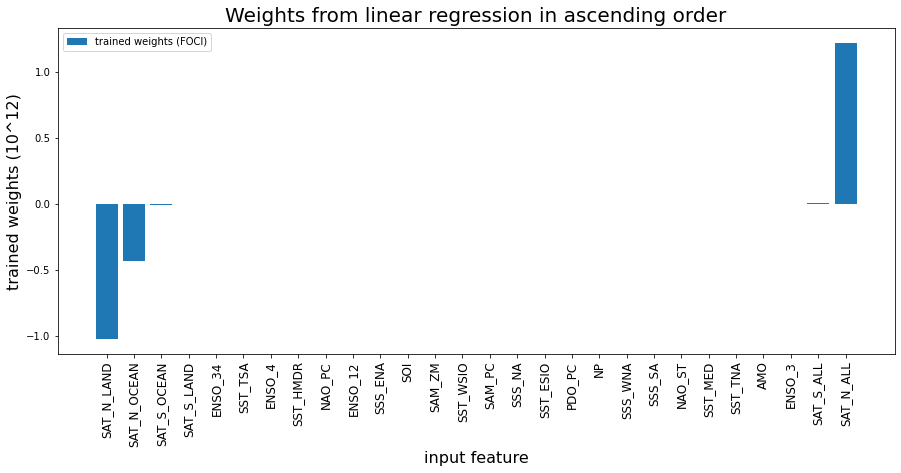

In [53]:
# Check trained weights from linear regression in ascending order:
fig, ax = plt.subplots(1,1,figsize=[15,6])
ax.bar(
    x=range(len(W)),
    height=W[np.argsort(W)]/1e12,
    label="trained weights (FOCI)",
)
ax.legend()
ax.set_title('Weights from linear regression in ascending order', fontsize=20)
ax.set_xlabel('input feature', fontsize=16)
ax.set_ylabel('trained weights (10^12)', fontsize=16)
plt.xticks(range(len(W)), train_input_FOCI.columns.values[np.argsort(W)], fontsize=12, rotation=90)

In [56]:
### LRP with MLP on TRAIN samples (FOCI) with POSITIVE target:

## Split train inputs according to target:
samples_pos = train_input_FOCI.values[(train_target_FOCI.values>0)[:,0]]

# Extract number of input features:
in_feat = samples_pos.shape[1]

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model_MLP.get_weights())

## Set input / hidden / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_hidden = model_weights[2]
b_hidden = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Initialize storage for mean relevance over all samples with positive target with correct dimensions:
R_all_pos = np.zeros(samples_pos.shape)

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_907/298401471.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model_MLP.get_weights())


In [59]:
#Loop over samples with positive target:
for sample_id in range(len(samples_pos)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_pos))
    
    # Get current sample:
    sample = samples_pos[sample_id:sample_id+1,:]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model_MLP.predict(sample)[0,0]

    ## Get outputs from first and second hidden layer, X_1 and X_2, respectively:

    # Define shortened models:
    model_X1 = Model(inputs, hidden_1, name='model_X1')
    model_X2 = Model(inputs, hidden_2, name='model_X2')

    # Get outputs on selected sample (forward-pass) from trained short models:
    X_1 = model_X1.predict(sample)[0]
    X_2 = model_X2.predict(sample)[0]

    # Get inputs U from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:]
    
    
    ## LRP: Only consider POSITIVE pre-activations for propagation rule.
  
    ## Start with connection of second HIDDEN layer (X_2) to single OUTPUT unit.
    R_i = ((np.multiply(X_2,W_out[:,0])>0) * np.multiply(X_2,W_out[:,0]) /
           sum((np.multiply(X_2,W_out[:,0])>0) * np.multiply(X_2,W_out[:,0]))) * abs(pred)

    # Continue with connection of first HIDDEN layer (X_1) to second HIDDEN layer (X_2).
    R_j = np.sum(((np.multiply(np.reshape(X_1, (len(X_1),1)),W_hidden)>0) * np.multiply(np.reshape(X_1, (len(X_1),1)),W_hidden) /
           np.sum((np.multiply(np.reshape(X_1, (len(X_1),1)),W_hidden)>0) * np.multiply(np.reshape(X_1, (len(X_1),1)),W_hidden),axis=0)) * R_i, axis=1)

    # And then take care about connection of INPUT layer to first HIDDEN layer (X_1).
    R_k = np.sum(((np.multiply(np.reshape(U, (in_feat,1)), W_in)>0) * np.multiply(np.reshape(U, (in_feat,1)), W_in) / 
                  np.sum((np.multiply(np.reshape(U, (in_feat,1)), W_in)>0) * np.multiply(np.reshape(U, (in_feat,1)), W_in),axis=0)) * R_j, axis=1)

    # Normalize relevance map to have sum of total relevance equal to ONE.
    # Simply divide by absolute prediction, which served as total relevance to start with:
    R_k /= abs(pred)

    # Store relevance for current sample:
    R_all_pos[sample_id,:] = R_k
    
# Get mean relevance for all samples with positive target for all input features:
R_all_mean_pos = np.mean(R_all_pos,axis=0)

sample:  1  from  377
sample:  2  from  377
sample:  3  from  377
sample:  4  from  377
sample:  5  from  377
sample:  6  from  377
sample:  7  from  377
sample:  8  from  377
sample:  9  from  377
sample:  10  from  377
sample:  11  from  377
sample:  12  from  377
sample:  13  from  377
sample:  14  from  377
sample:  15  from  377
sample:  16  from  377
sample:  17  from  377
sample:  18  from  377
sample:  19  from  377
sample:  20  from  377
sample:  21  from  377
sample:  22  from  377
sample:  23  from  377
sample:  24  from  377
sample:  25  from  377
sample:  26  from  377
sample:  27  from  377
sample:  28  from  377
sample:  29  from  377
sample:  30  from  377
sample:  31  from  377
sample:  32  from  377
sample:  33  from  377
sample:  34  from  377
sample:  35  from  377
sample:  36  from  377
sample:  37  from  377
sample:  38  from  377
sample:  39  from  377
sample:  40  from  377
sample:  41  from  377
sample:  42  from  377
sample:  43  from  377
sample:  44  from  3

sample:  349  from  377
sample:  350  from  377
sample:  351  from  377
sample:  352  from  377
sample:  353  from  377
sample:  354  from  377
sample:  355  from  377
sample:  356  from  377
sample:  357  from  377
sample:  358  from  377
sample:  359  from  377
sample:  360  from  377
sample:  361  from  377
sample:  362  from  377
sample:  363  from  377
sample:  364  from  377
sample:  365  from  377
sample:  366  from  377
sample:  367  from  377
sample:  368  from  377
sample:  369  from  377
sample:  370  from  377
sample:  371  from  377
sample:  372  from  377
sample:  373  from  377
sample:  374  from  377
sample:  375  from  377
sample:  376  from  377
sample:  377  from  377


([<matplotlib.axis.XTick at 0x1b64d37c0>,
 [Text(0, 0, 'NAO_PC'),
  Text(1, 0, 'SAM_ZM'),
  Text(2, 0, 'SAT_N_LAND'),
  Text(3, 0, 'ENSO_34'),
  Text(4, 0, 'SST_MED'),
  Text(5, 0, 'SOI'),
  Text(6, 0, 'SAT_S_LAND'),
  Text(7, 0, 'NAO_ST'),
  Text(8, 0, 'ENSO_3'),
  Text(9, 0, 'SAT_N_OCEAN'),
  Text(10, 0, 'PDO_PC'),
  Text(11, 0, 'SST_ESIO'),
  Text(12, 0, 'SSS_ENA'),
  Text(13, 0, 'ENSO_12'),
  Text(14, 0, 'NP'),
  Text(15, 0, 'SAT_S_OCEAN'),
  Text(16, 0, 'ENSO_4'),
  Text(17, 0, 'SSS_NA'),
  Text(18, 0, 'SST_TSA'),
  Text(19, 0, 'SAT_S_ALL'),
  Text(20, 0, 'SAM_PC'),
  Text(21, 0, 'SSS_WNA'),
  Text(22, 0, 'AMO'),
  Text(23, 0, 'SAT_N_ALL'),
  Text(24, 0, 'SST_HMDR'),
  Text(25, 0, 'SST_TNA'),
  Text(26, 0, 'SST_WSIO'),
  Text(27, 0, 'SSS_SA')])

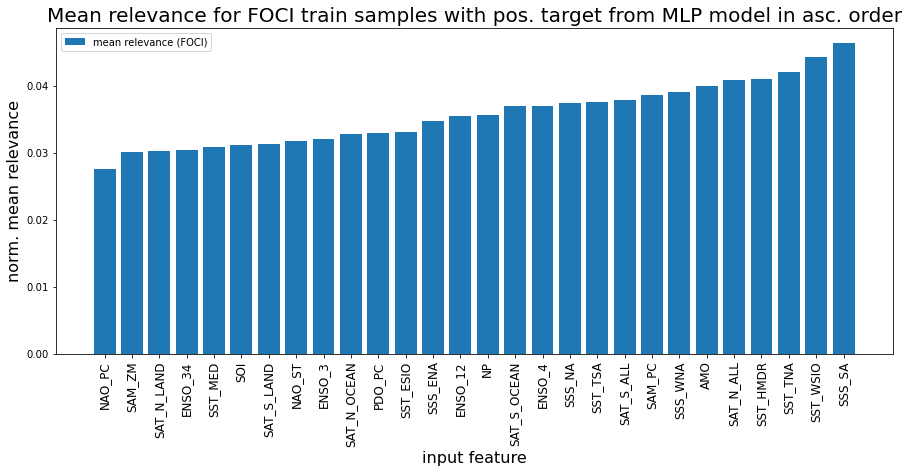

In [60]:
# Check relevance for all input features from MLP model in ascending order:
fig, ax = plt.subplots(1,1,figsize=[15,6])
ax.bar(
    x=range(len(R_all_mean_pos)),
    height=R_all_mean_pos[np.argsort(R_all_mean_pos)],
    label="mean relevance (FOCI)",
)
ax.legend()
ax.set_title('Mean relevance for FOCI train samples with pos. target from MLP model in asc. order', fontsize=20)
ax.set_xlabel('input feature', fontsize=16)
ax.set_ylabel('norm. mean relevance', fontsize=16)
plt.xticks(range(len(R_all_mean_pos)), train_input_FOCI.columns.values[np.argsort(R_all_mean_pos)], fontsize=12, rotation=90)

### Discussion on relevant input features

Find largest *absolute* values among trained weights from **linear regression** for sea air temperature (SAT) anomalies in the Northern Hemisphere. But that doesn't mean, that the model puts its focus mostly on these pedictors: Trained only on 'SAT_N_ALL', 'SAT_N_LAND' and 'SAT_N_OCEAN' both - MLP and linear regression - fail! And surprisingly sea-surface salinity (SSS) anomalies only get small weights in linear regression model. Would have expected SSS to play a bigger role for predicting Sahel Rainfall.

Mean relevance for all input features from **MLP model** on FOCI samples with positive targets show highest relevance for one of the SSS features, followed by an SAT feature and several sea-surface temperature (SST) anomalies. That appears to be more reasonable - on the first sight.

#### Next steps:

- Get mean relevance for samples with negative targets.
- Try also for MLP model trained on CESM samples.

### Erase collinearity by applying PCA to input features

As done by [Badr et al., 2014](https://doi.org/10.1175/JAMC-D-13-0181.1), use PCA to remove multicollinearity between predictor variables.

In [104]:
# Apply singular value decomposition to input features:
pc, s, eof = sp.linalg.svd(climind_FOCI_AMJ.values, full_matrices=False)

# Get transformed inputs:
climind_FOCI_AMJ_PC = np.multiply(pc,s)

In [109]:
# Squared singular values give the Eigenvalues:
s**2

array([5.95510459e+03, 3.22407046e+03, 2.61916842e+03, 2.32145400e+03,
       2.21987019e+03, 1.87140486e+03, 1.38759993e+03, 1.24436275e+03,
       9.69868007e+02, 8.79355214e+02, 7.76387532e+02, 6.91457247e+02,
       6.19969646e+02, 5.90350703e+02, 5.53668602e+02, 5.14728260e+02,
       3.90153541e+02, 3.43664132e+02, 2.98175816e+02, 2.10865716e+02,
       9.87441736e+01, 8.33071215e+01, 7.34535383e+01, 2.83285520e+01,
       2.45687110e+01, 9.91829966e+00, 1.93199406e-24, 7.88158245e-25])

In [107]:
# And the Eigenvalues are related to the variance captured by the PCs:
np.var(climind_FOCI_AMJ_PC,axis=0)

array([5.95510459e+00, 3.22407046e+00, 2.61916842e+00, 2.32145400e+00,
       2.21987019e+00, 1.87140486e+00, 1.38759993e+00, 1.24436275e+00,
       9.69868007e-01, 8.79355214e-01, 7.76387532e-01, 6.91457247e-01,
       6.19969646e-01, 5.90350703e-01, 5.53668602e-01, 5.14728260e-01,
       3.90153541e-01, 3.43664132e-01, 2.98175816e-01, 2.10865716e-01,
       9.87441736e-02, 8.33071215e-02, 7.34535383e-02, 2.83285520e-02,
       2.45687110e-02, 9.91829966e-03, 1.93199406e-27, 7.88158192e-28])

In [106]:
## Split inputs and targets into train and validation sets (80:20):

# Get split point:
split = int(len(climind_FOCI_AMJ_PC) * 0.8)

train_input_FOCI_PC = climind_FOCI_AMJ_PC[:split]
val_input_FOCI_PC = climind_FOCI_AMJ_PC[split:]
# train_input_CESM_PC = climind_CESM_AMJ_PC[:split]
# val_input_CESM_PC = climind_CESM_AMJ_PC[split:]

train_target_FOCI = prec_sahel_FOCI_JAS[:split]
val_target_FOCI = prec_sahel_FOCI_JAS[split:]
# train_target_CESM = prec_sahel_CESM_JAS[:split]
# val_target_CESM = prec_sahel_CESM_JAS[split:]

# Check dimensions:
print("train_input_FOCI shape (samples, features): ", train_input_FOCI_PC.shape)
#print("train_input_CESM shape (samples, features): ", train_input_CESM_PC.shape)
print("val_input_FOCI shape (samples, features): ", val_input_FOCI_PC.shape)
#print("val_input_CESM shape (samples, features): ", val_input_CESM_PC.shape)
print("\ntrain_target_FOCI shape (samples, features): ", train_target_FOCI.shape)
#print("train_target_CESM shape (samples, features): ", train_target_CESM.shape)
print("val_target_FOCI shape (samples, features): ", val_target_FOCI.shape)
#print("val_target_CESM shape (samples, features): ", val_target_CESM.shape)

train_input_FOCI shape (samples, features):  (800, 28)
val_input_FOCI shape (samples, features):  (200, 28)

train_target_FOCI shape (samples, features):  (800, 1)
val_target_FOCI shape (samples, features):  (200, 1)


In [111]:
### Linear regression on FOCI data

# Create vector of shape (samples, 1) containing ONEs to be added as additional column to train and val inputs.
train_input_add = np.ones((train_input_FOCI_PC.shape[0], 1))
val_input_add = np.ones((val_input_FOCI_PC.shape[0], 1))

# Now add vector of ONEs as additional column to train and validation inputs, omit time dimension:
train_input_prime = np.concatenate((train_input_FOCI_PC[:,:], train_input_add), axis=-1)
val_input_prime = np.concatenate((val_input_FOCI_PC[:,:], val_input_add), axis=-1)

# Then need pseudo-inverse of train inputs in augmented notation
train_input_prime_inv = np.linalg.pinv(train_input_prime)

# Then get output weights, in augmented notation
W_prime_PC = np.matmul(train_input_prime_inv, train_target_FOCI.values)

# Now extract weights and bias from augmented notation (W_prime), the last value is the bias:
W_PC = W_prime_PC[:-1,0]
b_PC = W_prime_PC[-1,0]

## Get model predictions on train and validation data:
train_pred_linReg_FOCI_PC = np.matmul(train_input_prime, W_prime_PC)
val_pred_linReg_FOCI_PC = np.matmul(val_input_prime, W_prime_PC)

Text(0, 0.5, 'norm. Anomaly (FOCI)')

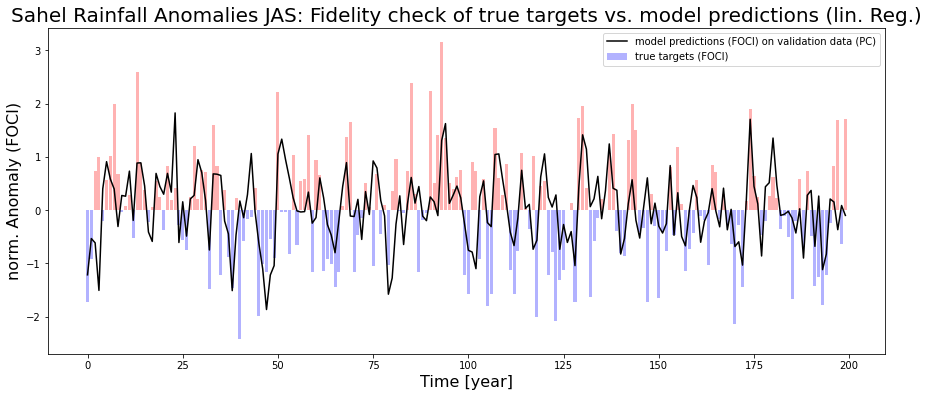

In [113]:
# Fidelity check: Plot VALIDATION targets as bar plot (red / blue) vs. predictions as black line (FOCI)
fig, ax = plt.subplots(1,1,figsize=[15,6])
ax.bar(
    x=range(len(prec_sahel_FOCI_JAS.values[split:,0])),
    height=prec_sahel_FOCI_JAS.values[split:,0],
    color=bar_color(prec_sahel_FOCI_JAS[split:],'r','b')[0],
    label="true targets (FOCI)",
    alpha=0.3
)
ax.plot(val_pred_linReg_FOCI_PC, label="model predictions (FOCI) on validation data (PC)", color='black')
ax.legend()
ax.set_title('Sahel Rainfall Anomalies JAS: Fidelity check of true targets vs. model predictions (lin. Reg.)', fontsize=20)
ax.set_xlabel('Time [year]', fontsize=16)
ax.set_ylabel('norm. Anomaly (FOCI)', fontsize=16)

In [114]:
# Check loss (mse) of true targets vs. model predictions:
print("Mean-squared error on train data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((train_pred_linReg_FOCI_PC[:,0] - train_target_FOCI.values[:,0])**2),3))
print("Mean-squared error on validation data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((val_pred_linReg_FOCI_PC[:,0] - val_target_FOCI.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_FOCI_PC[:,0], train_target_FOCI.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_FOCI_PC[:,0], val_target_FOCI.values[:,0]]))[0,1],3)
     )

Mean-squared error on train data (FOCI) with lin. Reg.:  0.864
Mean-squared error on validation data (FOCI) with lin. Reg.:  0.828

Correlation on train data (FOCI) with lin. Reg.:  0.547
Correlation on validation data (FOCI) with lin. Reg.:  0.495


In [112]:
W_PC[np.argsort(W_PC)]

array([-7.06306463e+10, -3.02955298e-01, -2.76823226e-01, -1.98120274e-01,
       -1.85984944e-01, -1.82999829e-01, -1.55961652e-01, -1.20234230e-01,
       -1.06369122e-01, -9.79862705e-02, -9.47042092e-02, -9.24308029e-02,
       -8.63669964e-02, -6.26207405e-02, -3.53151075e-02, -2.40548214e-02,
        1.03534907e-02,  2.02388691e-02,  2.40197130e-02,  4.86310142e-02,
        5.38777285e-02,  6.83313527e-02,  7.37527613e-02,  8.01288465e-02,
        1.25329635e-01,  1.63329595e-01,  5.44271353e-01,  1.66702599e+12])

### Discussion: Linear regression with PCs as inputs, rather than raw input features

Find exactly the same model performance. And still have two significant weights of order $10^{12}$.

### Repeat MLP for single run experiments on PCs of raw FOCI input features

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 28)]              0         
_________________________________________________________________
dense_55 (Dense)             (None, 20)                580       
_________________________________________________________________
dense_56 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 11        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
80/80 - 0s - loss: 3.1514 - correlation_coefficient: 0.0547 - val_loss: 2.2465 - val_correlation_coefficient: 0.1199
Epoch 2/10
80/80 - 0s - loss: 1.5063 - correlation_coefficient: 0.3053 - val_loss: 1.3378 - val_correlation_coefficient: 0.2697
Epoch 3

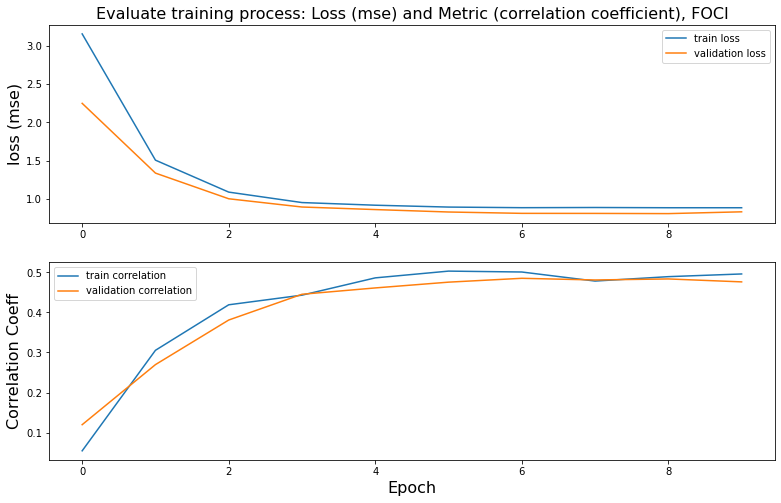

In [117]:
## Set parameters upfront:
lr = 0.0005 # Learning rate
epc = 10 # Number of epochs
batch_size = 10 # Batch size
in_features = train_input_FOCI_PC.shape[1] # Number of input features

# Optionally use L1 and/or L2 regularization drive small weights and/or bias to zero or penalize large weights
# and/or bias, respectively:
kernel_reg_Dense=tfr.l1_l2(l1=0, l2=0)
bias_reg_Dense=tfr.l1_l2(l1=0, l2=0) 

# Set up layers:
inputs = Input(shape=(in_features))
hidden_1 = Dense(20, activation='linear', kernel_regularizer=kernel_reg_Dense)(inputs)
hidden_2 = Dense(10, activation='linear', kernel_regularizer=kernel_reg_Dense)(hidden_1)
output = Dense(1, activation='linear')(hidden_2)

## Alternatively try more hidden layers with ReLU activation:
# # Set up layers:
# inputs = Input(shape=(in_features))
# hidden_1 = Dense(30, activation='relu')(inputs)
# hidden_2 = Dense(30, activation='relu')(hidden_1)
# hidden_3 = Dense(30, activation='relu')(hidden_2)
# hidden_4 = Dense(30, activation='relu')(hidden_3)
# output = Dense(1, activation='linear')(hidden_4)

# Define and compile model :
model_MLP = Model(inputs, output, name='MLP')
opt = Adam(lr=lr) #SGD(lr=lr)
model_MLP.compile(loss='mse', optimizer=opt, metrics=[correlation_coefficient])
model_MLP.summary()

## train model on FOCI data:
history = model_MLP.fit(train_input_FOCI_PC, train_target_FOCI, epochs=epc, verbose=2, shuffle=True,
                    batch_size=batch_size, validation_data=(val_input_FOCI_PC, val_target_FOCI))

# Plot loss (mse) and metric (correlation coefficient) on train and validation data (FOCI):
fig, axes = plt.subplots(2, 1, figsize=(13,8))
axes[0].set_title("Evaluate training process: Loss (mse) and Metric (correlation coefficient), FOCI", fontsize=16)
axes[0].plot(history.history['loss'], label='train loss'), 
axes[0].plot(history.history['val_loss'], label='validation loss')
axes[0].set_ylabel("loss (mse)", fontsize=16)
axes[0].legend()
axes[1].plot(history.history['correlation_coefficient'], label='train correlation'), 
axes[1].plot(history.history['val_correlation_coefficient'], label='validation correlation')
axes[1].set_ylabel("Correlation Coeff", fontsize=16)
axes[1].legend()
axes[1].set_xlabel("Epoch", fontsize=16)
plt.show()

## Get model predictions on train and validation data:
train_pred_MLP_FOCI_PC = model_MLP.predict(train_input_FOCI_PC)
val_pred_MLP_FOCI_PC = model_MLP.predict(val_input_FOCI_PC)

In [118]:
## Results from MLP model (PC):

# Check loss (mse) of true targets vs. model predictions:
print("MLP:\n====\nMean-squared error on train data (FOCI) with MLP: ", 
      np.round(np.mean((train_pred_MLP_FOCI_PC[:,0] - train_target_FOCI.values[:,0])**2),3))
print("Mean-squared error on validation data (FOCI) with MLP: ", 
      np.round(np.mean((val_pred_MLP_FOCI_PC[:,0] - val_target_FOCI.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (FOCI) with MLP: ",
      np.round(np.corrcoef(np.stack([train_pred_MLP_FOCI_PC[:,0], train_target_FOCI.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (FOCI) with MLP: ",
      np.round(np.corrcoef(np.stack([val_pred_MLP_FOCI_PC[:,0], val_target_FOCI.values[:,0]]))[0,1],3)
     )

## Compare with benchmark results from lin. Regression (PC)

# Check loss (mse) of true targets vs. model predictions:
print("\n\nlin. Regression:\n================\nMean-squared error on train data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((train_pred_linReg_FOCI_PC[:,0] - train_target_FOCI.values[:,0])**2),3))
print("Mean-squared error on validation data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((val_pred_linReg_FOCI_PC[:,0] - val_target_FOCI.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_FOCI_PC[:,0], train_target_FOCI.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_FOCI_PC[:,0], val_target_FOCI.values[:,0]]))[0,1],3)
     )

MLP:
====
Mean-squared error on train data (FOCI) with MLP:  0.869
Mean-squared error on validation data (FOCI) with MLP:  0.833

Correlation on train data (FOCI) with MLP:  0.543
Correlation on validation data (FOCI) with MLP:  0.489


lin. Regression:
Mean-squared error on train data (FOCI) with lin. Reg.:  0.864
Mean-squared error on validation data (FOCI) with lin. Reg.:  0.828

Correlation on train data (FOCI) with lin. Reg.:  0.547
Correlation on validation data (FOCI) with lin. Reg.:  0.495


In [120]:
### LRP with MLP on TRAIN samples (PC) (FOCI) with POSITIVE target:

## Split train inputs according to target:
samples_pos = train_input_FOCI_PC[(train_target_FOCI.values>0)[:,0]]

# Extract number of input features:
in_feat = samples_pos.shape[1]

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model_MLP.get_weights())

## Set input / hidden / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_hidden = model_weights[2]
b_hidden = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Initialize storage for mean relevance over all samples with positive target with correct dimensions:
R_all_pos = np.zeros(samples_pos.shape)

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_907/2524939483.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model_MLP.get_weights())


In [121]:
#Loop over samples with positive target:
for sample_id in range(len(samples_pos)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_pos))
    
    # Get current sample:
    sample = samples_pos[sample_id:sample_id+1,:]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model_MLP.predict(sample)[0,0]

    ## Get outputs from first and second hidden layer, X_1 and X_2, respectively:

    # Define shortened models:
    model_X1 = Model(inputs, hidden_1, name='model_X1')
    model_X2 = Model(inputs, hidden_2, name='model_X2')

    # Get outputs on selected sample (forward-pass) from trained short models:
    X_1 = model_X1.predict(sample)[0]
    X_2 = model_X2.predict(sample)[0]

    # Get inputs U from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:]
    
    
    ## LRP: Only consider POSITIVE pre-activations for propagation rule.
  
    ## Start with connection of second HIDDEN layer (X_2) to single OUTPUT unit.
    R_i = ((np.multiply(X_2,W_out[:,0])>0) * np.multiply(X_2,W_out[:,0]) /
           sum((np.multiply(X_2,W_out[:,0])>0) * np.multiply(X_2,W_out[:,0]))) * abs(pred)

    # Continue with connection of first HIDDEN layer (X_1) to second HIDDEN layer (X_2).
    R_j = np.sum(((np.multiply(np.reshape(X_1, (len(X_1),1)),W_hidden)>0) * np.multiply(np.reshape(X_1, (len(X_1),1)),W_hidden) /
           np.sum((np.multiply(np.reshape(X_1, (len(X_1),1)),W_hidden)>0) * np.multiply(np.reshape(X_1, (len(X_1),1)),W_hidden),axis=0)) * R_i, axis=1)

    # And then take care about connection of INPUT layer to first HIDDEN layer (X_1).
    R_k = np.sum(((np.multiply(np.reshape(U, (in_feat,1)), W_in)>0) * np.multiply(np.reshape(U, (in_feat,1)), W_in) / 
                  np.sum((np.multiply(np.reshape(U, (in_feat,1)), W_in)>0) * np.multiply(np.reshape(U, (in_feat,1)), W_in),axis=0)) * R_j, axis=1)

    # Normalize relevance map to have sum of total relevance equal to ONE.
    # Simply divide by absolute prediction, which served as total relevance to start with:
    R_k /= abs(pred)

    # Store relevance for current sample:
    R_all_pos[sample_id,:] = R_k
    
# Get mean relevance for all samples with positive target for all input features:
R_all_mean_pos = np.mean(R_all_pos,axis=0)

sample:  1  from  377
sample:  2  from  377
sample:  3  from  377
sample:  4  from  377
sample:  5  from  377
sample:  6  from  377
sample:  7  from  377
sample:  8  from  377
sample:  9  from  377
sample:  10  from  377
sample:  11  from  377
sample:  12  from  377
sample:  13  from  377
sample:  14  from  377
sample:  15  from  377
sample:  16  from  377
sample:  17  from  377
sample:  18  from  377
sample:  19  from  377
sample:  20  from  377
sample:  21  from  377
sample:  22  from  377
sample:  23  from  377
sample:  24  from  377
sample:  25  from  377
sample:  26  from  377
sample:  27  from  377
sample:  28  from  377
sample:  29  from  377
sample:  30  from  377
sample:  31  from  377
sample:  32  from  377
sample:  33  from  377
sample:  34  from  377
sample:  35  from  377
sample:  36  from  377
sample:  37  from  377
sample:  38  from  377
sample:  39  from  377
sample:  40  from  377
sample:  41  from  377
sample:  42  from  377
sample:  43  from  377
sample:  44  from  3

sample:  348  from  377
sample:  349  from  377
sample:  350  from  377
sample:  351  from  377
sample:  352  from  377
sample:  353  from  377
sample:  354  from  377
sample:  355  from  377
sample:  356  from  377
sample:  357  from  377
sample:  358  from  377
sample:  359  from  377
sample:  360  from  377
sample:  361  from  377
sample:  362  from  377
sample:  363  from  377
sample:  364  from  377
sample:  365  from  377
sample:  366  from  377
sample:  367  from  377
sample:  368  from  377
sample:  369  from  377
sample:  370  from  377
sample:  371  from  377
sample:  372  from  377
sample:  373  from  377
sample:  374  from  377
sample:  375  from  377
sample:  376  from  377
sample:  377  from  377


([<matplotlib.axis.XTick at 0x1ba0169d0>,
 [Text(0, 0, '28'),
  Text(1, 0, '27'),
  Text(2, 0, '26'),
  Text(3, 0, '25'),
  Text(4, 0, '24'),
  Text(5, 0, '23'),
  Text(6, 0, '22'),
  Text(7, 0, '21'),
  Text(8, 0, '20'),
  Text(9, 0, '19'),
  Text(10, 0, '18'),
  Text(11, 0, '17'),
  Text(12, 0, '16'),
  Text(13, 0, '15'),
  Text(14, 0, '14'),
  Text(15, 0, '13'),
  Text(16, 0, '12'),
  Text(17, 0, '11'),
  Text(18, 0, '10'),
  Text(19, 0, '9'),
  Text(20, 0, '8'),
  Text(21, 0, '7'),
  Text(22, 0, '6'),
  Text(23, 0, '5'),
  Text(24, 0, '4'),
  Text(25, 0, '3'),
  Text(26, 0, '2'),
  Text(27, 0, '1')])

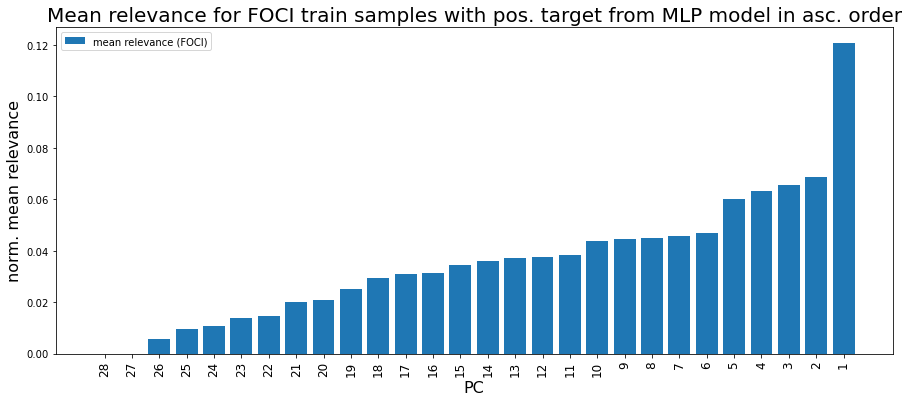

In [129]:
# Check relevance for all input features from MLP model in ascending order:
fig, ax = plt.subplots(1,1,figsize=[15,6])
ax.bar(
    x=range(len(R_all_mean_pos)),
    height=R_all_mean_pos[np.argsort(R_all_mean_pos)],
    label="mean relevance (FOCI)",
)
ax.legend()
ax.set_title('Mean relevance for FOCI train samples with pos. target from MLP model in asc. order', fontsize=20)
ax.set_xlabel('PC', fontsize=16)
ax.set_ylabel('norm. mean relevance', fontsize=16)
plt.xticks(range(len(R_all_mean_pos)), np.flip(np.arange(0,len(R_all_mean_pos))+1), fontsize=12, rotation=90)

### Discussion on PC as pre-processing step

Linear regression performance is identical for raw inputs and PCs, at least in terms of mse and correlation of predictions and true targets. Still find two weights of order $10^{12}$ with opposite sign.

MLP performance is also not found to be improved by training models on PCs, instead of raw input features. But see significant change in LRP: First PC has by far highest relevance.